In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from seaborn.palettes import light_palette, dark_palette
from matplotlib.colors import to_hex

In [23]:
# df = pd.read_excel(r'E:\Backup\IT Works Cyberpro Data Analyst\Final Python Project\formatted_for_sbrn.xlsx')

In [24]:
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 22,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 18,
    'legend.title_fontsize': 20,
    'font.family': 'Calibri'  # or 'Arial', 'DejaVu Sans', etc.
})

In [25]:
# 1. Prepare the Global Data
# Configuration
SUM_INDICATORS = ["Market Size", "Subscribers"]
selected_indicators = ["ARPU", "Penetration Rate", "Market Size", "Subscribers"]
selected_names = ["World"]
selected_years = sorted(df["Year"].unique())
if 2024 in selected_years:
    selected_years.remove(2024)

# Prepare combined chart data
combined_chart_data = pd.DataFrame()

for selected_indicator in selected_indicators:
    df_filtered = df[df["Year"].isin(selected_years)]
    chart_data = pd.DataFrame()

    for name in selected_names:
        sub = df_filtered  # "World" means using full dataset

        if selected_indicator == "ARPU":
            ms = sub[sub["Key Indicator"] == "Market Size"].groupby("Year")["Value"].sum()
            subs = sub[sub["Key Indicator"] == "Subscribers"].groupby("Year")["Value"].sum()
            val = (ms / subs / 12).reset_index(name="Value")
        elif selected_indicator == "Penetration Rate":
            subs = sub[sub["Key Indicator"] == "Subscribers"].groupby("Year")["Value"].sum()
            pop = sub[sub["Key Indicator"] == "Population"].groupby("Year")["Value"].sum()
            val = (subs / pop).reset_index(name="Value")
        else:
            sub = sub[sub["Key Indicator"] == selected_indicator]
            if selected_indicator in SUM_INDICATORS:
                val = sub.groupby("Year")["Value"].sum().reset_index()
            else:
                val = sub.groupby("Year")["Value"].mean().reset_index()

        val["Country"] = name
        val["Indicator"] = selected_indicator
        chart_data = pd.concat([chart_data, val], ignore_index=True)

    if chart_data.empty:
        print(f"❌ No data found for '{selected_indicator}'.")
        continue

    if selected_indicator in SUM_INDICATORS:
        chart_data["Value"] /= 1_000_000  # millions
    if selected_indicator == "Penetration Rate":
        chart_data["Value"] *= 100  # percent

    combined_chart_data = pd.concat([combined_chart_data, chart_data], ignore_index=True)

if combined_chart_data.empty:
    print("❌ No data found for any selected indicator.")
    exit()

NameError: name 'df' is not defined

In [ ]:
# Pivot to wide format for correlation analysis
global_wide = combined_chart_data.pivot(index="Year", columns="Indicator", values="Value").dropna()
if 2024 in global_wide.index:
    global_wide = global_wide.drop(2024)

# Compute correlations
corr_arpu_pen = global_wide["ARPU"].corr(global_wide["Penetration Rate"])
corr_ms_subs = global_wide["Market Size"].corr(global_wide["Subscribers"])

print(f"\n📊 Correlation between ARPU and Penetration Rate: {corr_arpu_pen:.2f}")
print(f"📊 Correlation between Market Size and Subscribers: {corr_ms_subs:.2f}") 


📊 Correlation between ARPU and Penetration Rate: -0.95
📊 Correlation between Market Size and Subscribers: -0.75


In [ ]:
# 3. Chart Settings
# Colors
base_colors = ["#C00000", "#FF6600", "#203864"]
shades = (
    light_palette("#C00000", 5, reverse=True)[1:] +
    dark_palette("#FF6600", 5, reverse=True)[1:] +
    light_palette("#203864", 5, reverse=True)[1:]
)
full_colors = base_colors + [to_hex(c) for c in shades]
palette_dict = dict(zip(["ARPU", "Penetration Rate", "Market Size", "Subscribers"], full_colors[:4]))

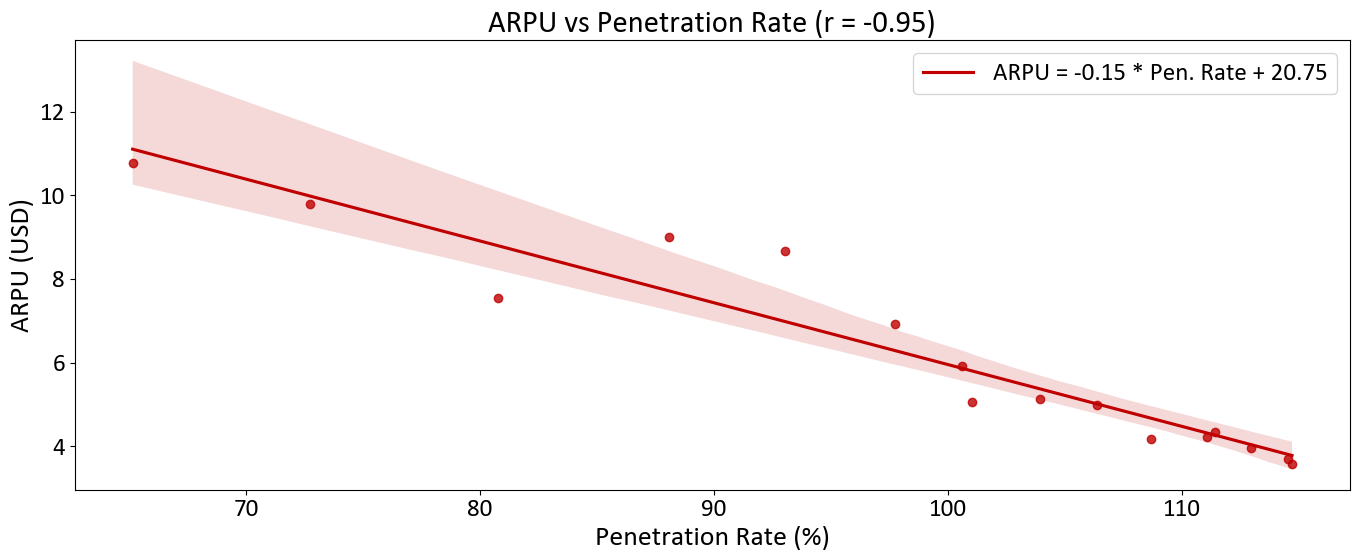

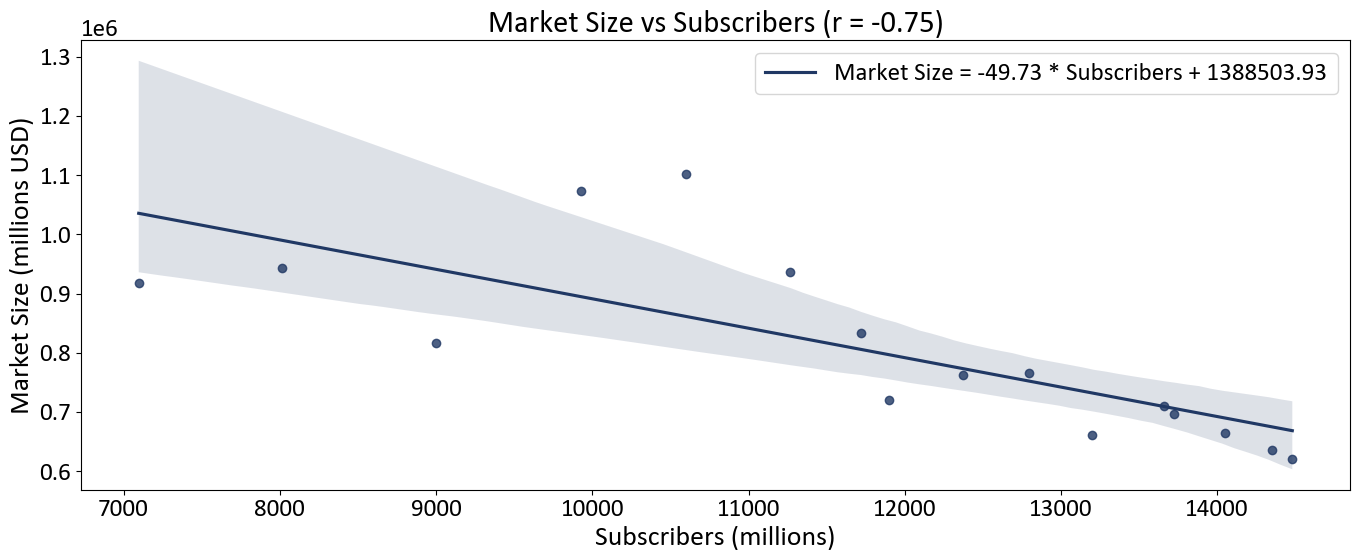

In [ ]:
# 4. Plot the Correlations
# === 1. ARPU vs Penetration Rate ===
x1 = global_wide["Penetration Rate"]
y1 = global_wide["ARPU"]
slope1, intercept1 = np.polyfit(x1, y1, 1)
reg_eq1 = f"ARPU = {slope1:.2f} * Pen. Rate + {intercept1:.2f}"

plt.figure(figsize=(14, 6))
sns.regplot(x=x1, y=y1, color=palette_dict["ARPU"], line_kws={"label": reg_eq1})
plt.xlabel("Penetration Rate (%)")
plt.ylabel("ARPU (USD)")
plt.title(f"ARPU vs Penetration Rate (r = {corr_arpu_pen:.2f})")
plt.legend()
plt.tight_layout()
plt.show()

# === 2. Market Size vs Subscribers ===
x2 = global_wide["Subscribers"]
y2 = global_wide["Market Size"]
slope2, intercept2 = np.polyfit(x2, y2, 1)
reg_eq2 = f"Market Size = {slope2:.2f} * Subscribers + {intercept2:.2f}"

plt.figure(figsize=(14, 6))
sns.regplot(x=x2, y=y2, color=palette_dict["Market Size"], line_kws={"label": reg_eq2})
plt.xlabel("Subscribers (millions)")
plt.ylabel("Market Size (millions USD)")
plt.title(f"Market Size vs Subscribers (r = {corr_ms_subs:.2f})")
plt.legend()
plt.tight_layout()
plt.show()


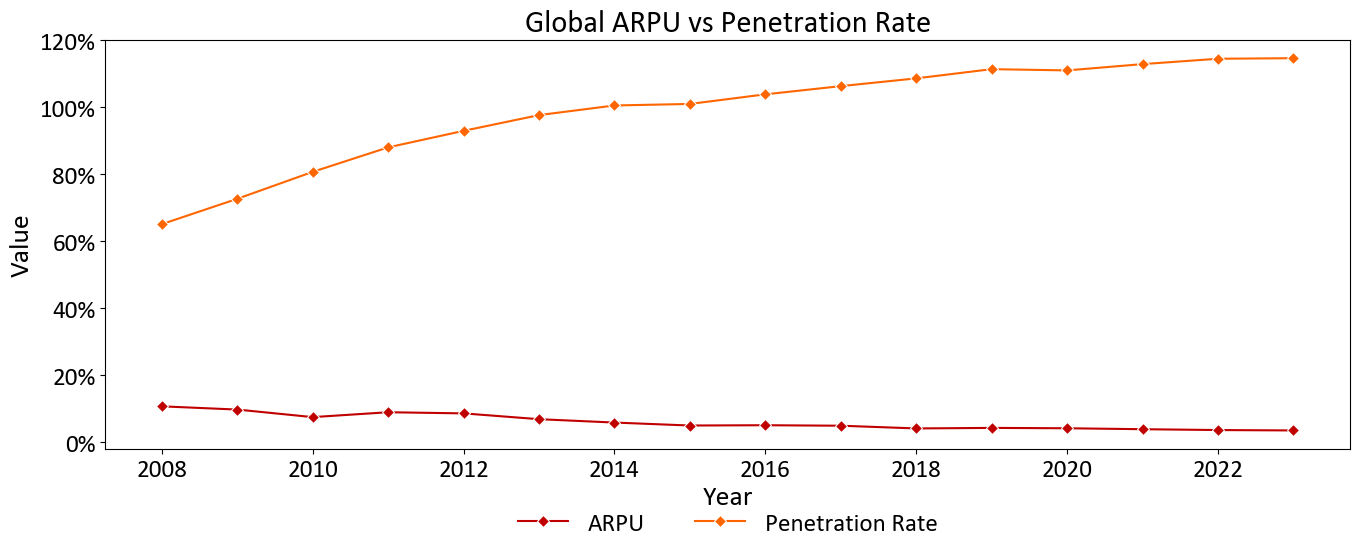

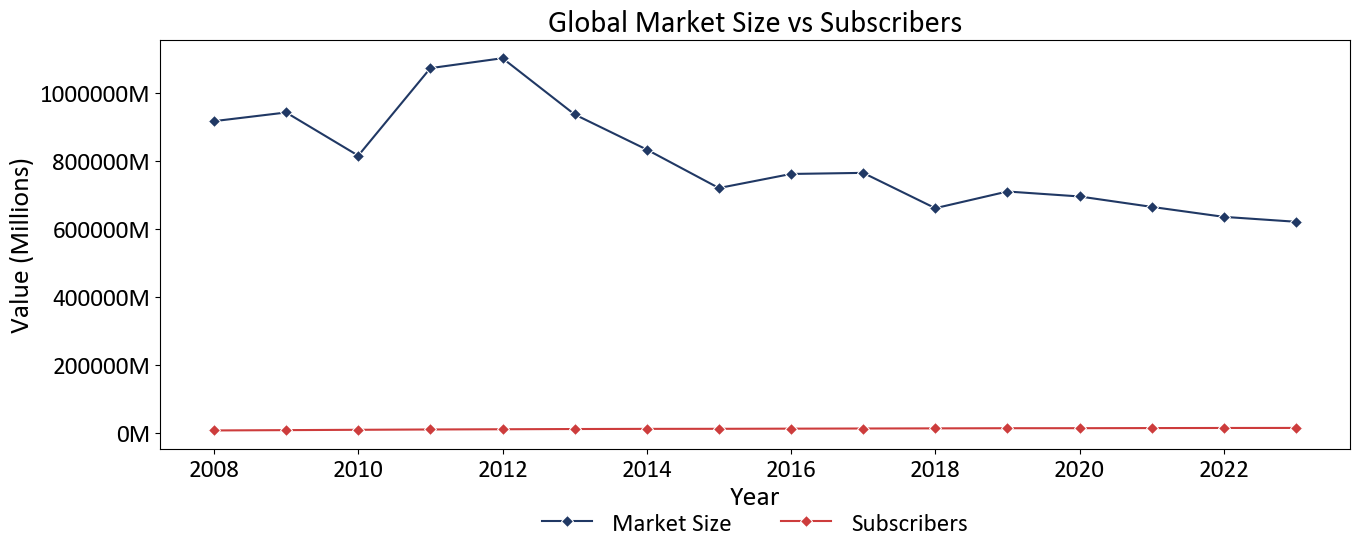

In [ ]:
# 1. ARPU vs Penetration Rate
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=combined_chart_data[combined_chart_data["Indicator"].isin(["ARPU", "Penetration Rate"])],
                  x="Year", y="Value", hue="Indicator", marker="D", palette=palette_dict)
ax.set_xlabel("Year")
ax.set_ylabel("Value")
if "Penetration Rate" in combined_chart_data["Indicator"].unique():
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
else:
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter("%.1f"))

ax.legend(title="", frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.title("Global ARPU vs Penetration Rate")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Market Size vs Subscribers
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=combined_chart_data[combined_chart_data["Indicator"].isin(["Market Size", "Subscribers"])],
                  x="Year", y="Value", hue="Indicator", marker="D", palette=palette_dict)
ax.set_xlabel("Year")
ax.set_ylabel("Value (Millions)")
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x:.0f}M'))
ax.legend(title="", frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.title("Global Market Size vs Subscribers")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
